# Credit Card Fraud Detection # 

Author: Hien Le

<img src="https://securityintelligence.com/wp-content/webp-express/webp-images/doc-root/wp-content/uploads/2016/09/credit-card-fraud-remains-a-risk.jpg.webp" alt="Image Description" style="width: 300px;"/>

## Context ## 
Credit card companies must possess the capability to detect fraudulent credit card transactions to ensure customers aren't billed for unauthorized purchases.

Three questions we will answer in this notebook
1. How can we compare the performance of different models?
2. Can we say somethings about the importance level of the features in the dataset? 
3. Explore some models and which one among them is the best for credit card fraud detection task? 

## The dataset ##
The dataset is downloaded from [kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data)


The dataset comprises credit card transactions made by European cardholders in September 2013. Within a span of two days, there were 492 fraudulent transactions out of a total of 284,807 transactions. This dataset is characterized by significant imbalance, with the positive class (frauds) representing only 0.172% of all transactions.

The dataset includes solely numerical input variables resulting from a PCA transformation. Due to confidentiality constraints, the original features or additional background information about the data are not provided. Principal component analysis (PCA) was applied to derive features V1 through V28; however, features 'Time' and 'Amount' were not subjected to PCA transformation. 'Time' denotes the elapsed seconds between each transaction and the first recorded transaction in the dataset, while 'Amount' represents the transaction amount. The 'Class' feature serves as the response variable, taking a value of 1 in cases of fraud and 0 otherwise.

## Data preparation and observation ## 
1. The data has the shape (284807, 31); there are 29 feature columns.
2. There are no nan values in the data
3. The dataset is imbalanced

In [16]:
# import packages
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import matplotlib.pyplot  as plt
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from pyod.models.ecod import ECOD
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [14]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [2]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [2]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

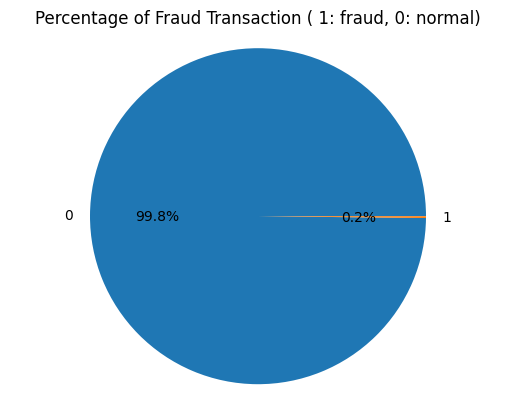

In [2]:
#the dataset is imbalanced
transaction_counts = df['Class'].value_counts()
plt.pie(transaction_counts, labels=transaction_counts.index, autopct='%1.1f%%')
plt.title('Percentage of Fraud Transaction ( 1: fraud, 0: normal)')
plt.axis('equal')
plt.show()

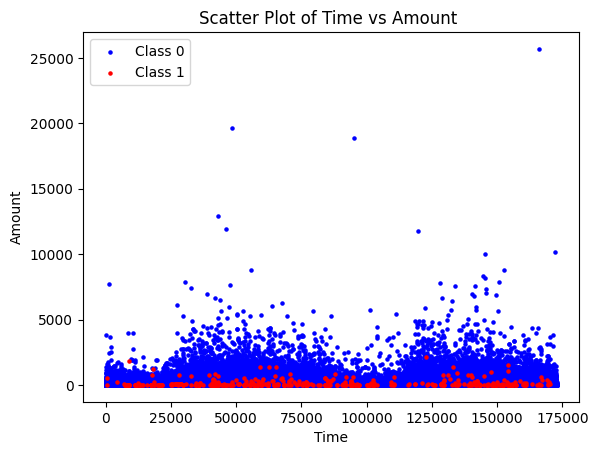

In [7]:
class_1_df = df[df['Class'] == 1]  # Data with class 1
class_0_df = df[df['Class'] == 0]  # Data with class 0
plt.scatter(class_0_df['Time'], class_0_df['Amount'], color='blue', label='Class 0',s=5)
plt.scatter(class_1_df['Time'], class_1_df['Amount'], color='red', label='Class 1',s=5)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('Scatter Plot of Time vs Amount ')
plt.legend()

In [15]:
# data
y=df['Class']
X=df.drop(columns=["Time","Class"])
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Q1: How can we compare the performance of different models? ##

In essence, Credit Card Fraud Detection involves identifying anomalies within credit card transactions, making it an anomaly detection task. When evaluating the performance of anomaly detection models, we typically rely on the following criteria. Note that positive = anomaly, negative = normality. 

|          | Predicted Negative | Predicted Positive |
|----------|--------------------|--------------------|
| Actual Negative | TN               | FP               |
| Actual Positive | FN               | TP               |


- **Precision and Recall**: Precision represents the proportion of correctly identified anomalies among all instances labeled as anomalies by the model, while recall measures the proportion of true anomalies that are correctly identified by the model.
  $$Precision= \frac{TP}{TP+FP}$$
  $$Recall= \frac{TP}{TP + FN} $$ 

- **F1 Score**: The F1 score is the harmonic mean of precision and recall and provides a balanced measure of a model's performance.
$$F1 Score=2 \times \frac{Precision×Recall}{Precision+Recall}$$

- **Area Under the ROC Curve (AUC-ROC)**: The ROC curve plots the true positive rate against the false positive rate at various threshold settings. AUC-ROC provides a single scalar value that represents the overall performance of the model across different threshold settings.

- **Area Under the Precision-Recall Curve (AUC-PR)**: Similar to AUC-ROC, AUC-PR summarizes the precision-recall curve's performance, particularly useful when dealing with imbalanced datasets.

## Q2. Can we say somethings about the importance level of the features in the dataset?

In fact, the feature importance depends much on the model we use. 

Let us first use Ordinary Least Squares (OLS) regression from the statsmodels library to fit a linear regression model and obtain p-values for each feature coefficient. These p-values indicate the statistical significance of each feature in predicting the target variable. **In the context of linear regression**, if the p-value is less than a chosen significance level (commonly 0.05), it suggests that the corresponding feature has a statistically significant relationship with the target variable; a high p-value suggests that the corresponding feature may not have a statistically significant relationship with the target variable. Features with low p-values are likely to be important predictors, while features with high p-values may be less relevant and could potentially be removed from the model. **Note that using p-value is sometimes controversial.**

In [4]:
model = OLS(y, X_scaled).fit()
pvalues = pd.DataFrame(model.pvalues)
pvalues.reset_index(inplace=True)
pvalues.rename(columns={0: "pvalue", "index": "feature"}, inplace=True)
pvalues.style.background_gradient(cmap='RdYlGn')

#We observe that feature V23 has a high p-value when using OLS regression model. 

,feature,pvalue
0,x1,0.000000
1,x2,0.000000
2,x3,0.000000
3,x4,0.000000
4,x5,0.000000
5,x6,0.000000
6,x7,0.000000
7,x8,0.000000
8,x9,0.000000
9,x10,0.000000


Tree-based models such as Decision Trees, Random Forests, and Gradient Boosting Machines can provide feature importance scores. These scores represent the relative importance of each feature in the model's decision-making process. Features with higher importance scores are considered more significant in predicting the target variable. Let us try DecisionTreeClassifier from scikit-learn to train a decision tree model and then extract feature importances from it.  

In [5]:
# Initialize DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier()

# Fit the model
dt_classifier.fit(X_scaled, y)

# Get feature importances
feature_importances = dt_classifier.feature_importances_
feature_importances 


array([0.01376993, 0.        , 0.        , 0.01270139, 0.01084216,
       0.00554404, 0.02170728, 0.01700824, 0.00452999, 0.04641565,
       0.01067129, 0.04259439, 0.01112811, 0.10256964, 0.01011434,
       0.01764428, 0.53171309, 0.00366075, 0.01304033, 0.01153109,
       0.00552898, 0.00747443, 0.00945978, 0.0182207 , 0.00537719,
       0.01952054, 0.03648535, 0.00770663, 0.0030404 ])

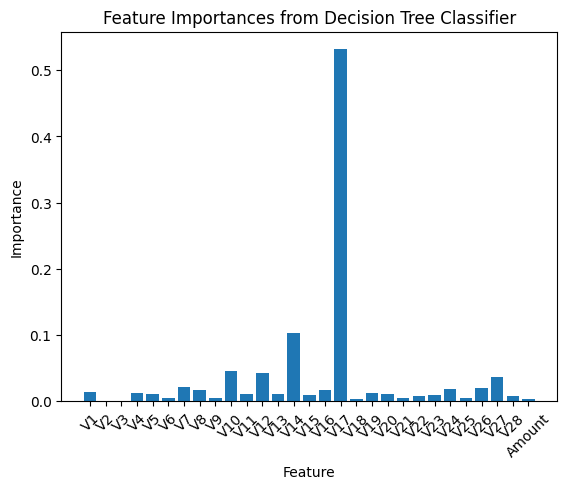

In [6]:
# Plot feature importances
plt.bar(range(len(feature_importances)), feature_importances, tick_label=X.columns)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances from Decision Tree Classifier')
plt.xticks(rotation=45)
plt.show()

## Explore some AD models for fraud credit card detection task 

We will try the following AD models 
- The usual logistic regression model 
- Decision Tree Classifier
- Isolation Forest
- Empirical Cumulative Distribution-based Outlier Detection 

In [17]:
scaler = StandardScaler()

logistic_regression = LogisticRegression()
dt_classifier = DecisionTreeClassifier()
isolation_forest = IsolationForest()
ecod = ECOD()

# Create pipelines with StandardScaler and models
pipeline_lr = Pipeline([('scaler', scaler), ('lr', logistic_regression)])
pipeline_dt = Pipeline([('scaler', scaler), ('dt', dt_classifier)])
pipeline_if = Pipeline([('scaler', scaler), ('if', isolation_forest)])
pipeline_ecod = Pipeline([('scaler', scaler), ('ecod', ecod)])

# Define multiple metrics
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average='macro'),
           'recall': make_scorer(recall_score, average='macro'),
           'f1-score': make_scorer(f1_score, average='macro'),
           'auc_roc':make_scorer(roc_auc_score),
           'auc_pr': make_scorer(average_precision_score)
          }

## Evaluation ## 

In [18]:
# evaluation function that returns the mean scores
def evaluation(pipeline_model,X,y,scoring):
   cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
   scores =cross_validate(pipeline_model, X, y, cv=cv, scoring=scoring)
   scores=pd.DataFrame(scores)
   scores=scores.mean()
   return scores

In [19]:
# logistic regression evaluation
scores_lr_mean=evaluation(pipeline_lr, X, y, scoring=scoring)

In [20]:
# decision tree evaluation
scores_dt_mean =evaluation(pipeline_dt, X, y, scoring=scoring)

In [21]:
# isolation tree evaluation
y_is=y.values
y_is=y_is*2-1
scores_if_mean =evaluation(pipeline_if, X, y_is, scoring=scoring)

In [22]:
#this is an unsupervised method ECOD evaluation
scores_ecod_mean =evaluation(pipeline_ecod, X, y, scoring=scoring)

C:\Users\lethi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\lethi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\lethi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\lethi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\lethi\A

In [23]:
results=pd.concat([scores_lr_mean,scores_dt_mean,scores_if_mean,scores_ecod_mean],axis=1)
results.columns=['logistic regression','decision tree','isolated forest','ECOD']

In [24]:
results

,logistic regression,decision tree,isolated forest,ECOD
fit_time,0.496468,15.684587,0.358725,2.474490
score_time,0.057266,0.056008,0.255208,2.796384
test_accuracy,0.999171,0.999224,0.036962,0.901347
test_precision,0.936744,0.890791,0.481192,0.507547
test_recall,0.804767,0.885030,0.101692,0.893781
test_f1-score,0.858345,0.887056,0.035677,0.489068
test_auc_roc,0.804767,0.885030,0.101692,0.893781
test_auc_pr,0.533359,0.601923,0.001491,0.013779


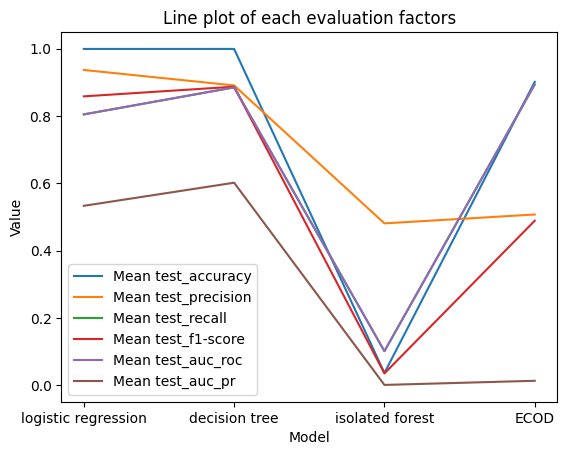

In [25]:
for index, row in results.drop(['fit_time','score_time']).iterrows():
    plt.plot(row.index, row.values, label=f'Mean {index}')

# Add labels and legend
plt.xlabel('Model')
plt.ylabel('Value')
plt.title('Line plot of each evaluation factors')
plt.legend()
plt.show()

## Deployment ## 

We observe that decision tree has the slowest fitting time among the models but it has the best accuracy, recall, f1-score, auc-roc and auc-pr scores. Logistic regression is the second best in these scores, it has the best precision score, and much faster fitting time than the decision tree model. It seems logistic regression is a good supervised method for fraud card detection task. ECOD also works quite well. Note that ECOD is unsupervised method. 